<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-Required-Packages" data-toc-modified-id="Importing-Required-Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing Required Packages</a></span></li><li><span><a href="#Importing-Dataset" data-toc-modified-id="Importing-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing Dataset</a></span></li><li><span><a href="#Train-Test-Split" data-toc-modified-id="Train-Test-Split-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train Test Split</a></span></li><li><span><a href="#GARCH-Model" data-toc-modified-id="GARCH-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>GARCH Model</a></span><ul class="toc-item"><li><span><a href="#Estimating-Signitficant-Lags" data-toc-modified-id="Estimating-Signitficant-Lags-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Estimating Signitficant Lags</a></span></li><li><span><a href="#Building-a-GARCH(2,-2)-Model" data-toc-modified-id="Building-a-GARCH(2,-2)-Model-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Building a GARCH(2, 2) Model</a></span></li></ul></li></ul></div>

# Importing Required Packages

In [1]:
# !pip install arch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss

from sklearn.metrics import mean_squared_error

from arch import arch_model

import warnings

sns.set()
warnings.filterwarnings("ignore")

# Importing Dataset

In [3]:
file_path = "../data.csv"

In [4]:
data_backup = pd.read_csv(file_path)
data_backup.Date = pd.to_datetime(data_backup.Date)
data_backup.set_index("Date", inplace = True)

In [5]:
data = data_backup[["spx_vol", "spx_ret"]]

# Train Test Split

In [6]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

# GARCH Model

## Estimating Signitficant Lags

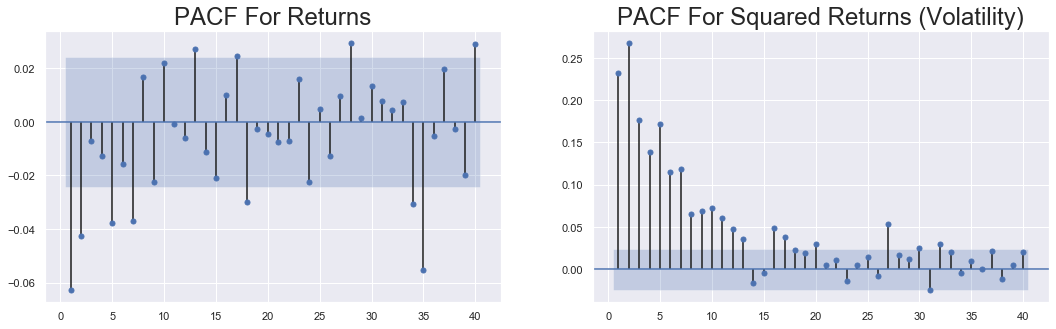

In [7]:
plt.rcParams["figure.figsize"] = 18, 5

fig, axes = plt.subplots(1, 2)

sgt.plot_pacf(train_df.spx_ret[1:], zero = False, lags = 40, ax = axes[0])
# sgt.plot_pacf(train_df.spx_ret[1:].abs(), zero = False, lags = 40, ax = axes[1])
sgt.plot_pacf(train_df.spx_vol[1:], zero = False, lags = 40, ax = axes[1])

axes[0].set_title("PACF For Returns", size = 24)
axes[1].set_title("PACF For Squared Returns (Volatility)", size = 24)

plt.show()

Looking at the **PACF** plots for returns and Volatility, it is clear that the first 2 lags are very significant and then the significance levels drop significantly. So we will build a **GARCH(2, 2)** Model.

## Building a GARCH(2, 2) Model

**Model Instantiation**

In [8]:
test_model = arch_model(data["spx_ret"][1:], p = 2, q = 2, mean = "Constant", vol = "GARCH")
results_test_model = test_model.fit(last_obs = test_df.index[0], update_freq = 5)

Iteration:      5,   Func. Count:     53,   Neg. LLF: 8630.607727933648
Iteration:     10,   Func. Count:     99,   Neg. LLF: 8627.660213616935
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 8627.645162303854
            Iterations: 14
            Function evaluations: 133
            Gradient evaluations: 14


**Model Summary**

In [9]:
results_test_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_ret   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -8627.65
Distribution:                  Normal   AIC:                           17267.3
Method:            Maximum Likelihood   BIC:                           17308.0
                                        No. Observations:                 6517
Date:                Fri, Oct 02 2020   Df Residuals:                     6511
Time:                        13:54:54   Df Model:                            6
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0628  9.674e-03      6.491  8.516e-11 [4.384e-02,8.176e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0257  6.715e-03      3.821  1.331e-04 [1.249e-02,3.882e-02]
alpha[1]       0.0608  1.568e-02      3.875  1.067e-04 [3.003e-02,9.149e-02]
alpha[2]       0.0976  2.144e-02      4.552  5.302e-06   [5.560e-02,  0.140]
beta[1]        0.3081      0.137      2.245  2.479e-02   [3.908e-02,  0.577]
beta[2]        0.5133      0.127      4.051  5.101e-05     [  0.265,  0.762]
============================================================================

Covariance estimator: robust
"""

**Model Predictions**

In [10]:
test_predictions = results_test_model.forecast(horizon = 1, align = "target")

**Plotting Predictions**

In [11]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = test_predictions.residual_variance[test_df.index[0]:test_df.index[-1]]

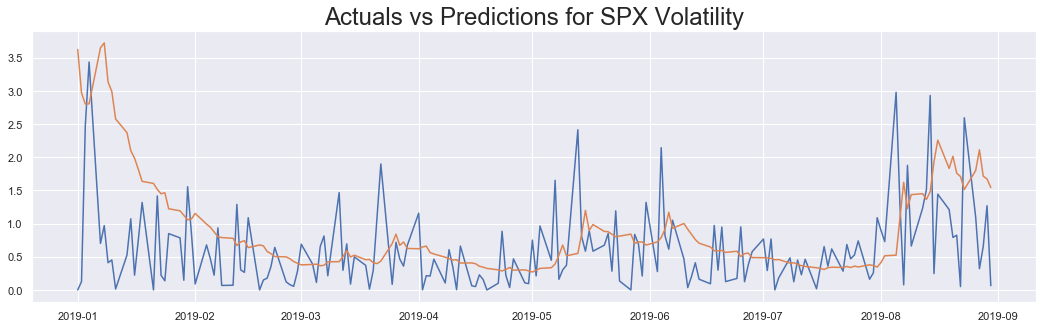

In [12]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["spx_ret"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size = 24)

plt.show()

**RMSE**

In [14]:
np.sqrt(mean_squared_error(predictions_df["spx_ret"].abs(), predictions_df["Predictions"]))

0.8750581051309496